In [1]:
import pystan
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import scipy as sp

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Hard

## 10H1

In [2]:
chimp = pd.read_csv('/Users/benjaminwee/Documents/courses/resources/Rethinking/Data/chimpanzees.csv',
                    sep = ';')

## This doesn't work, stan requires index to start at 1
# Reset index to zero
#chimp.actor = chimp.actor -1

In [40]:
chimp.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


In [41]:
h1_1 = """
data {
    int N; // number of rows
    int<lower=0, upper=1> L[N]; // Binary outcome variable
    int<lower=1, upper=N> chimp_idx; // creating chimp index for chimp zero chimp 1 chimp 2
    int<lower=1, upper=chimp_idx> chimp[N]; // nth chimp in the data belongs to indexed chimp value
 
    vector[N] P; // Data for prosoc_left
    vector[N] PC; // Data for interactive variable
}
parameters {
    real bP;
    real bPC;
    real a_chimp[chimp_idx];
}
model {
    vector[N] p;
    target += normal_lpdf(bP | 0, 10);
    target += normal_lpdf(bPC | 0, 10);
    target += normal_lpdf(a_chimp | 0, 10);
    for (n in 1:N) p[n] = a_chimp[chimp[n]] + (bP + bPC * PC[n]) * P[n];
    target += binomial_logit_lpmf(L | 1, p);
}
generated quantities {
    vector[N] log_lik;
    {
    vector[N] p;
    for (n in 1:N){
        p[n] = a_chimp[chimp[n]] + (bP + bPC * PC[n]) * P[n];
        log_lik[n] = binomial_logit_lpmf(L[n] | 1, p[n]);
        }
    }
}
"""

In [42]:
sm = pystan.StanModel(model_code=h1_1)
fit_h1_1 = sm.sampling(data=df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ccf21df4481defffe972556bf4803f3e NOW.


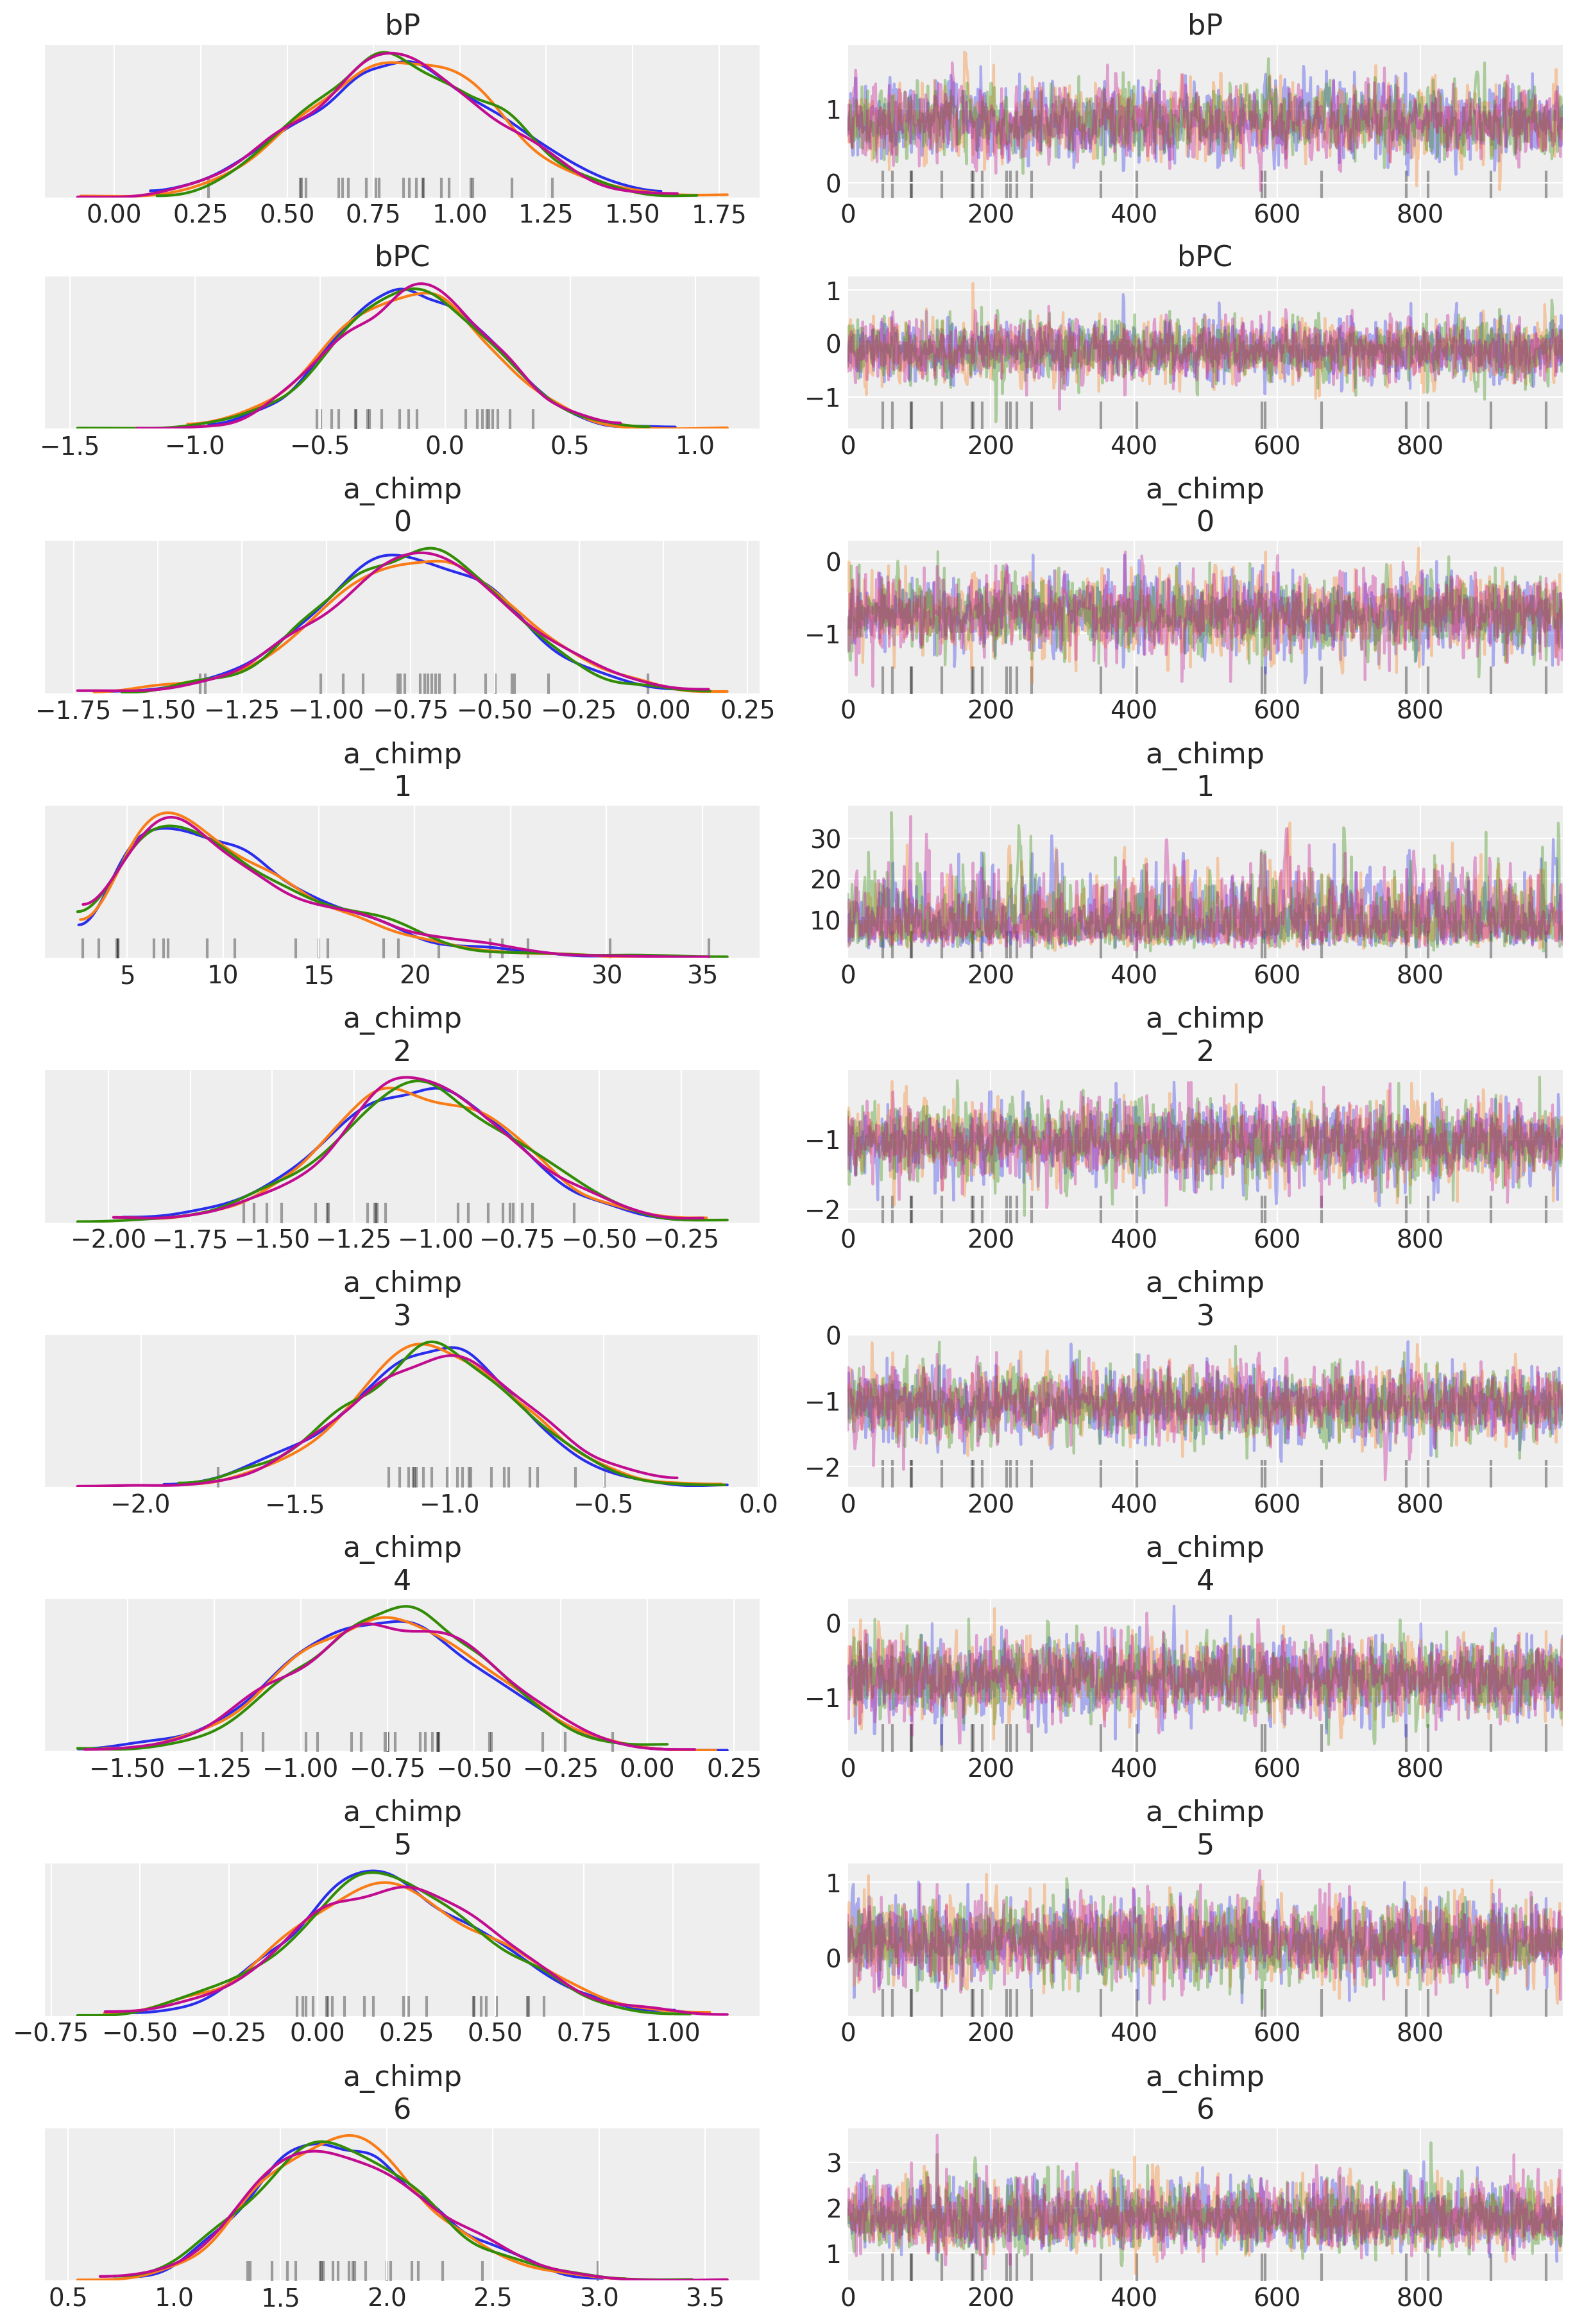

In [6]:
# Weak priors, used more informative priors in pymc3 example with much better results
samples_h1_1 = az.from_pystan(posterior=fit_h1_1)
az.plot_trace(samples_h1_1);

## 10H2

In [19]:
h2_1 = """
data {
    int N; // number of rows
    int<lower=0, upper=1> L[N]; // Binary outcome variable
}
parameters {
    real a_chimp;
}
model {
    vector[N] p;
    target += normal_lpdf(a_chimp | 0, 10);
    for(n in 1:N) p[n]=a_chimp;
    target += binomial_logit_lpmf(L | 1, p);
}
generated quantities {
    vector[N] log_lik;
    {
    vector[N] p;
    for (n in 1:N){
        p[n] = a_chimp;
        log_lik[n] = binomial_logit_lpmf(L[n] | 1, p[n]);
        }
    }
}
"""

h2_2 = """
data {
    int N; // number of rows
    int<lower=0, upper=1> L[N]; // Binary outcome variable
    vector[N] P; // Data for prosoc_left
}
parameters {
    real a_chimp;
    real bP;
}
model {
    vector[N] p;
    target += normal_lpdf(a_chimp | 0, 10);
    for(n in 1:N) p[n]=a_chimp + bP * P[n];
    target += binomial_logit_lpmf(L | 1, p);
}
generated quantities {
    vector[N] log_lik;
    {
    vector[N] p;
    for (n in 1:N){
        p[n] = a_chimp + bP * P[n];
        log_lik[n] = binomial_logit_lpmf(L[n] | 1, p[n]);
        }
    }
}
"""

h2_3 = """
data {
    int N; // number of rows
    int<lower=0, upper=1> L[N]; // Binary outcome variable
    vector[N] P; // Data for prosoc_left
    vector[N] PC;
}
parameters {
    real a_chimp;
    real bP;
    real bPC;
}
model {
    vector[N] p;
    target += normal_lpdf(a_chimp | 0, 10);
    for(n in 1:N) p[n]=a_chimp + (bPC * PC[n] + bP) * P[n];
    target += binomial_logit_lpmf(L | 1, p);
}
generated quantities {
    vector[N] log_lik;
    {
    vector[N] p;
    for (n in 1:N){
        p[n] = a_chimp + (bPC * PC[n] + bP) * P[n];
        log_lik[n] = binomial_logit_lpmf(L[n] | 1, p[n]);
        }
    }
}
"""

In [20]:
df = dict(N=len(chimp),
          L = chimp['pulled_left'],
          P = chimp['prosoc_left'],
          PC = chimp['condition'])

sm_h2_1 = pystan.StanModel(model_code=h2_1)
sm_h2_2 = pystan.StanModel(model_code=h2_2)
sm_h2_3 = pystan.StanModel(model_code=h2_3)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0f004ada81f754e2fc333d770a418d01 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b6da58f53b7864ed5d287717c69516c5 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c319d9484cecca355050eb6164d67cd3 NOW.


In [21]:
fit_h2_1 = sm_h2_1.sampling(data=df)
fit_h2_2 = sm_h2_2.sampling(data=df)
fit_h2_3 = sm_h2_3.sampling(data=df)

In [40]:
ll_h1_1 = az.from_pystan(fit_h1_1, log_likelihood="log_lik")
ll_h2_1 = az.from_pystan(fit_h2_1, log_likelihood="log_lik")
ll_h2_2 = az.from_pystan(fit_h2_2, log_likelihood="log_lik")
ll_h2_3 = az.from_pystan(fit_h2_3, log_likelihood="log_lik")

compare_dict = {'h1_1' : ll_h1_1,
                'h2_1' : ll_h2_1,
                'h2_2' : ll_h2_1,
                'h2_3' : ll_h2_3}

az.compare(compare_dict, ic="waic")

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
h1_1,0,529.969,8.37575,0,1,19.8594,0,False,deviance
h2_3,1,682.19,2.92502,152.221,1.39918e-21,7.06613,19.083,False,deviance
h2_1,2,688.056,1.05713,158.087,1.44803e-22,8.99452,19.8486,False,deviance
h2_2,3,688.056,1.05713,158.087,1.44803e-22,7.06613,19.8486,False,deviance


## 10H3

In [2]:
eagles = pd.read_csv('/Users/benjaminwee/Documents/courses/resources/Rethinking/Data/eagles.csv',
                    sep = ';')

# Create dummy variables
dummy_vars = pd.get_dummies(eagles[['P', 'A', 'V']]).iloc[:, ::2]
dummy_vars.columns = ["P", "A", "V"]

# Create dataset
df = eagles.iloc[:, 0:2].join(dummy_vars)

In [98]:
df.head()

,y,n,P,A,V
0,17,24,1,1,1
1,29,29,1,1,0
2,17,27,1,0,1
3,20,20,1,0,0
4,1,12,0,1,1


In [3]:
h3_1 = '''
data {
    int<lower=0> N;
    int<lower=0> y[N]; // Number of pulls
    int<lower=0> T[N]; // Number of trials
    vector[N] P;
    vector[N] A;
    vector[N] V;
}
parameters {
    real a;
    real bP;
    real bA;
    real bV;
}
model {
    vector[N] p;
    target += normal_lpdf(bP | 0,5);
    target += normal_lpdf(bA | 0,5);
    target += normal_lpdf(bV | 0,5);
    
    for(n in 1:N) p[n] = a + bP * P[n] + bA * A[n] + bV * V[n];
    target += binomial_logit_lpmf(y | T, p);
}
generated quantities {
    vector[N] log_lik;
    vector[N] y_hat;
    vector[N] p;
    {
    for(n in 1:N){
        p[n] = a + bP * P[n] + bA * A[n] + bV * V[n];
        log_lik[n] = binomial_logit_lpmf(y[n] | T[n], p[n]);
        y_hat[n] = binomial_rng(T[n], inv_logit(p[n]));
        } 
    }
}
'''

In [4]:
eagles_df = dict(N=len(df),
                 y = df['y'],
                 T = df['n'],
                 P = df['P'],
                 A = df['A'],
                 V = df['V'])

sm_h3_1 = pystan.StanModel(model_code=h3_1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6add8fb4128c5ea84cba39454f51277b NOW.


In [5]:
fit_h3_1 = sm_h3_1.sampling(data=eagles_df)
fit_h3_1

Inference for Stan model: anon_model_6add8fb4128c5ea84cba39454f51277b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a            0.65    0.02   0.71  -0.66   0.17   0.64   1.11   2.11   1735    1.0
bP           4.64    0.03   0.99   2.99   3.95   4.54   5.21    6.8   1497    1.0
bA           1.14    0.01   0.54   0.08   0.78   1.13   1.51   2.22   2330    1.0
bV          -5.04    0.03   1.07  -7.39  -5.66  -4.95  -4.32  -3.22   1441    1.0
log_lik[1]  -2.73    0.02   1.16  -5.87  -3.16  -2.31  -1.88  -1.73   2715    1.0
log_lik[2]  -0.08  1.8e-3   0.09  -0.32   -0.1  -0.05  -0.02-4.1e-3   2191    1.0
log_lik[3]  -2.54    0.02   0.91  -5.22   -2.8   -2.2  -1.93  -1.85   3029    1.0
log_lik[4]  -0.17  4.0e-3   0.18  -0.67  -0.21  -0.11  -0.05-9.0e-3   2084    1.0
log_lik[5]  -1.42    0.02   0.59  -2.97  -1.62   -1.2  -1.02  -0.96   118

In [32]:
fit_df = sm_h3_1.sampling(data=eagles_df).to_dataframe()
fit_df

,chain,draw,warmup,a,bP,bA,bV,log_lik[1],log_lik[2],log_lik[3],...,p[6],p[7],p[8],lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,1.220553,4.098765,0.962746,-4.909386,-2.275411,-0.054166,-1.895382,...,2.183299,-3.688833,1.220553,-18.866514,0.987140,0.210669,4,15,0,21.092034
1,0,1,0,1.417688,5.282236,0.258295,-5.378446,-2.799770,-0.027560,-3.650803,...,1.675983,-3.960758,1.417688,-22.646535,0.664103,0.210669,4,15,0,24.204915
2,0,2,0,0.887819,3.981592,0.188680,-4.307943,-1.780307,-0.183789,-1.852051,...,1.076499,-3.420125,0.887819,-20.007720,0.909932,0.210669,4,31,0,24.569469
3,0,3,0,-0.882255,5.074877,2.528923,-4.469689,-5.409212,-0.034915,-3.994914,...,1.646668,-5.351944,-0.882255,-22.104516,0.896245,0.210669,4,15,0,23.666130
4,0,4,0,1.309016,4.344623,0.493790,-4.799207,-2.224057,-0.061964,-2.168849,...,1.802806,-3.490191,1.309016,-19.859295,0.832493,0.210669,4,19,0,24.044837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3,995,0,0.694792,4.431652,1.315601,-5.561802,-1.732923,-0.046164,-4.925366,...,2.010393,-4.867009,0.694792,-20.641276,0.726551,0.172006,3,11,0,23.476446
3996,3,996,0,0.862550,4.533090,1.423190,-5.568861,-2.041752,-0.031680,-3.474336,...,2.285740,-4.706311,0.862550,-19.459843,1.000000,0.172006,3,11,0,21.657726
3997,3,997,0,0.937537,4.648273,1.512301,-5.354269,-3.319719,-0.023963,-2.137063,...,2.449838,-4.416732,0.937537,-19.337436,0.932553,0.172006,4,15,0,20.400360
3998,3,998,0,0.387301,5.077792,0.193201,-5.033569,-1.909699,-0.100989,-1.880240,...,0.580502,-4.646268,0.387301,-21.725286,0.967598,0.172006,4,15,0,23.135019


In [7]:
samples_h3_1 = az.from_pystan(posterior=fit_h3_1)

In [8]:
az.plot_trace(samples_h3_1, ['~log_lik*', '~p*', '~y_hat*']);

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### 10H3b

In [24]:
trace_frame = fit_df.filter(regex=('p\[')) 

Text(0,0.5,'Parameter p')

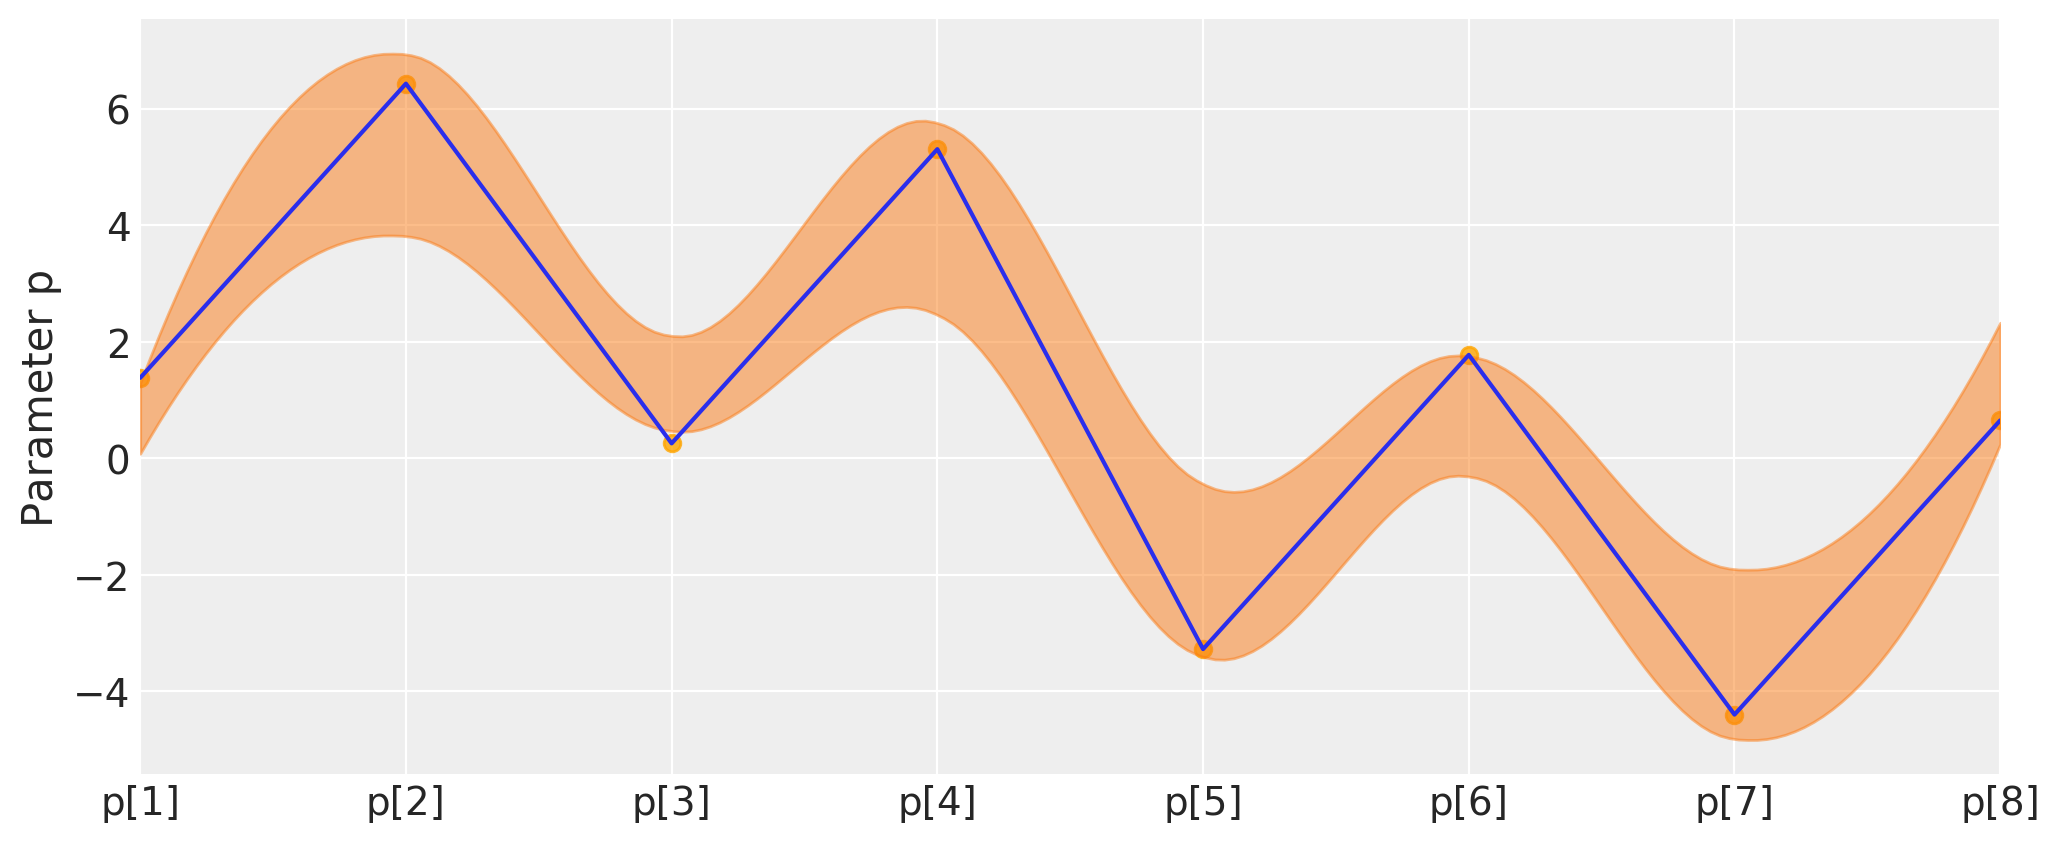

In [25]:
# Don't know why hpd refuses to display properly
import matplotlib.pyplot as plt
prob = trace_frame.mean(0)

plt.figure(figsize=(12,5))
plt.scatter(df.index, prob, color='orange', alpha=0.8)
prob.plot()
az.plot_hpd(df.index, trace_frame, credible_interval=0.89);
plt.ylabel("Parameter p")

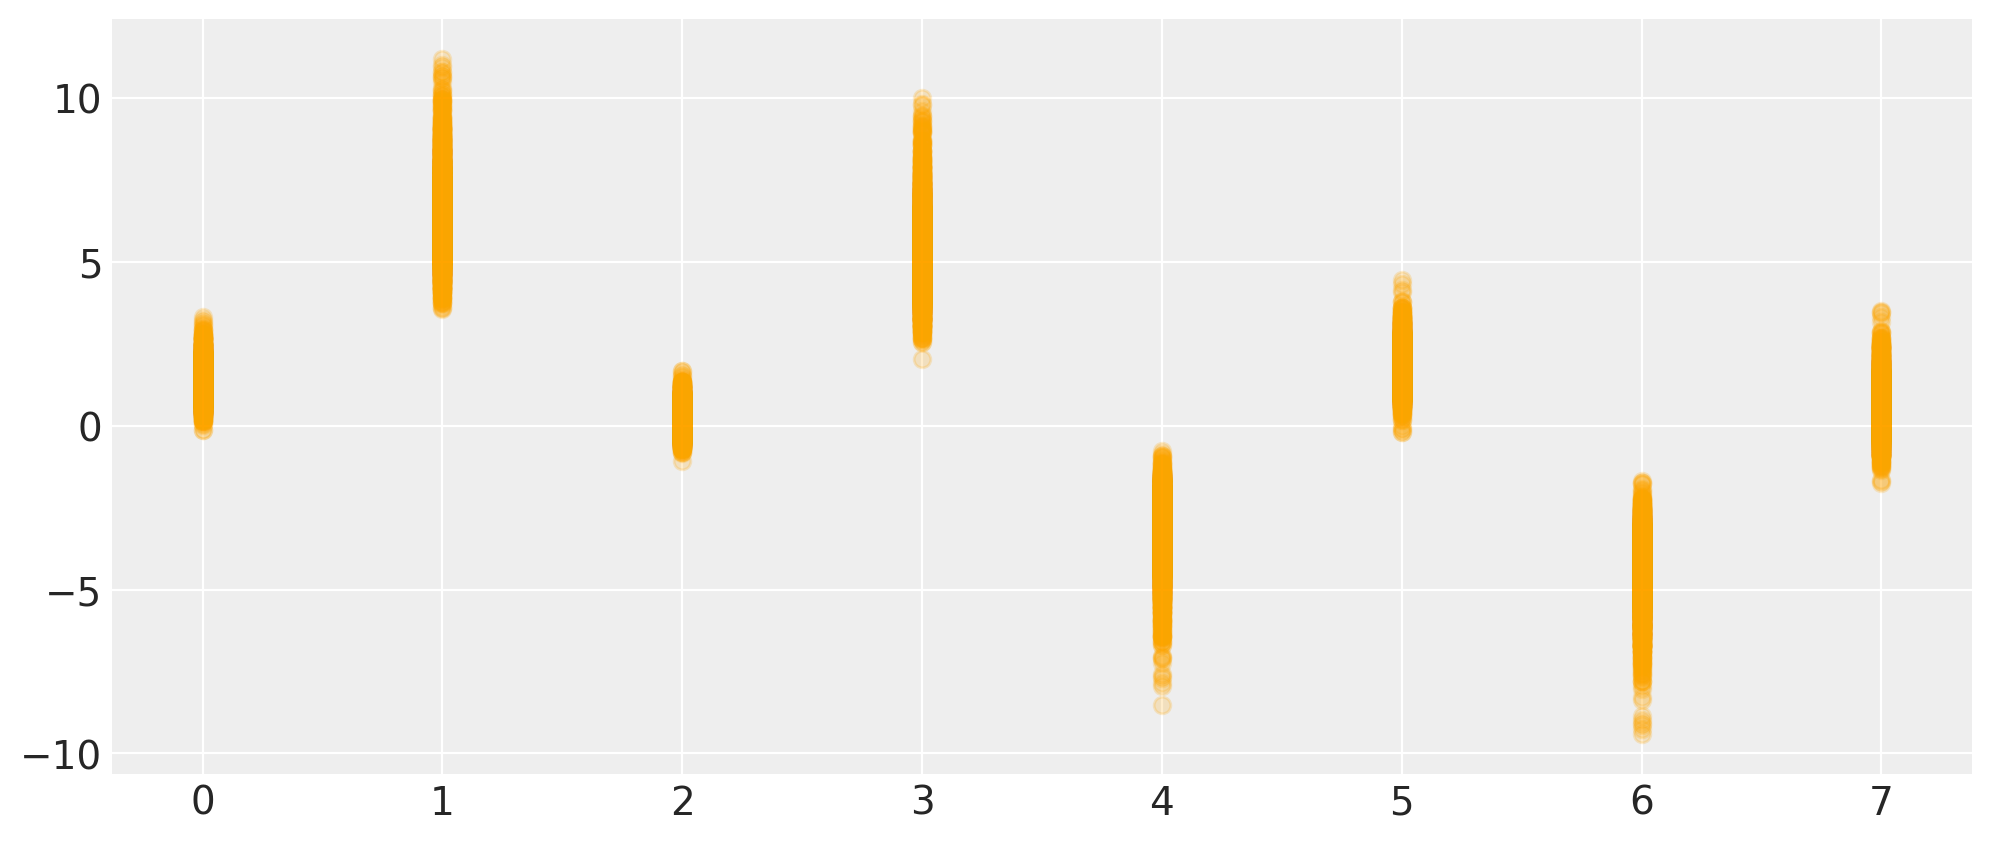

In [30]:
# Distribution of p at each outcome
plt.figure(figsize=(12,5))

for i in range(len(trace_frame)):
    plt.scatter(df.index, trace_frame.T[i], color='orange', alpha=0.2)


Get posterior predictions

In [37]:
post_pred_check_df = fit_df.filter(regex=('y\_h')) 

Text(0.5,1,'Posterior predicted counts\nGreen - Observed outcome, blue - predicted outcome')

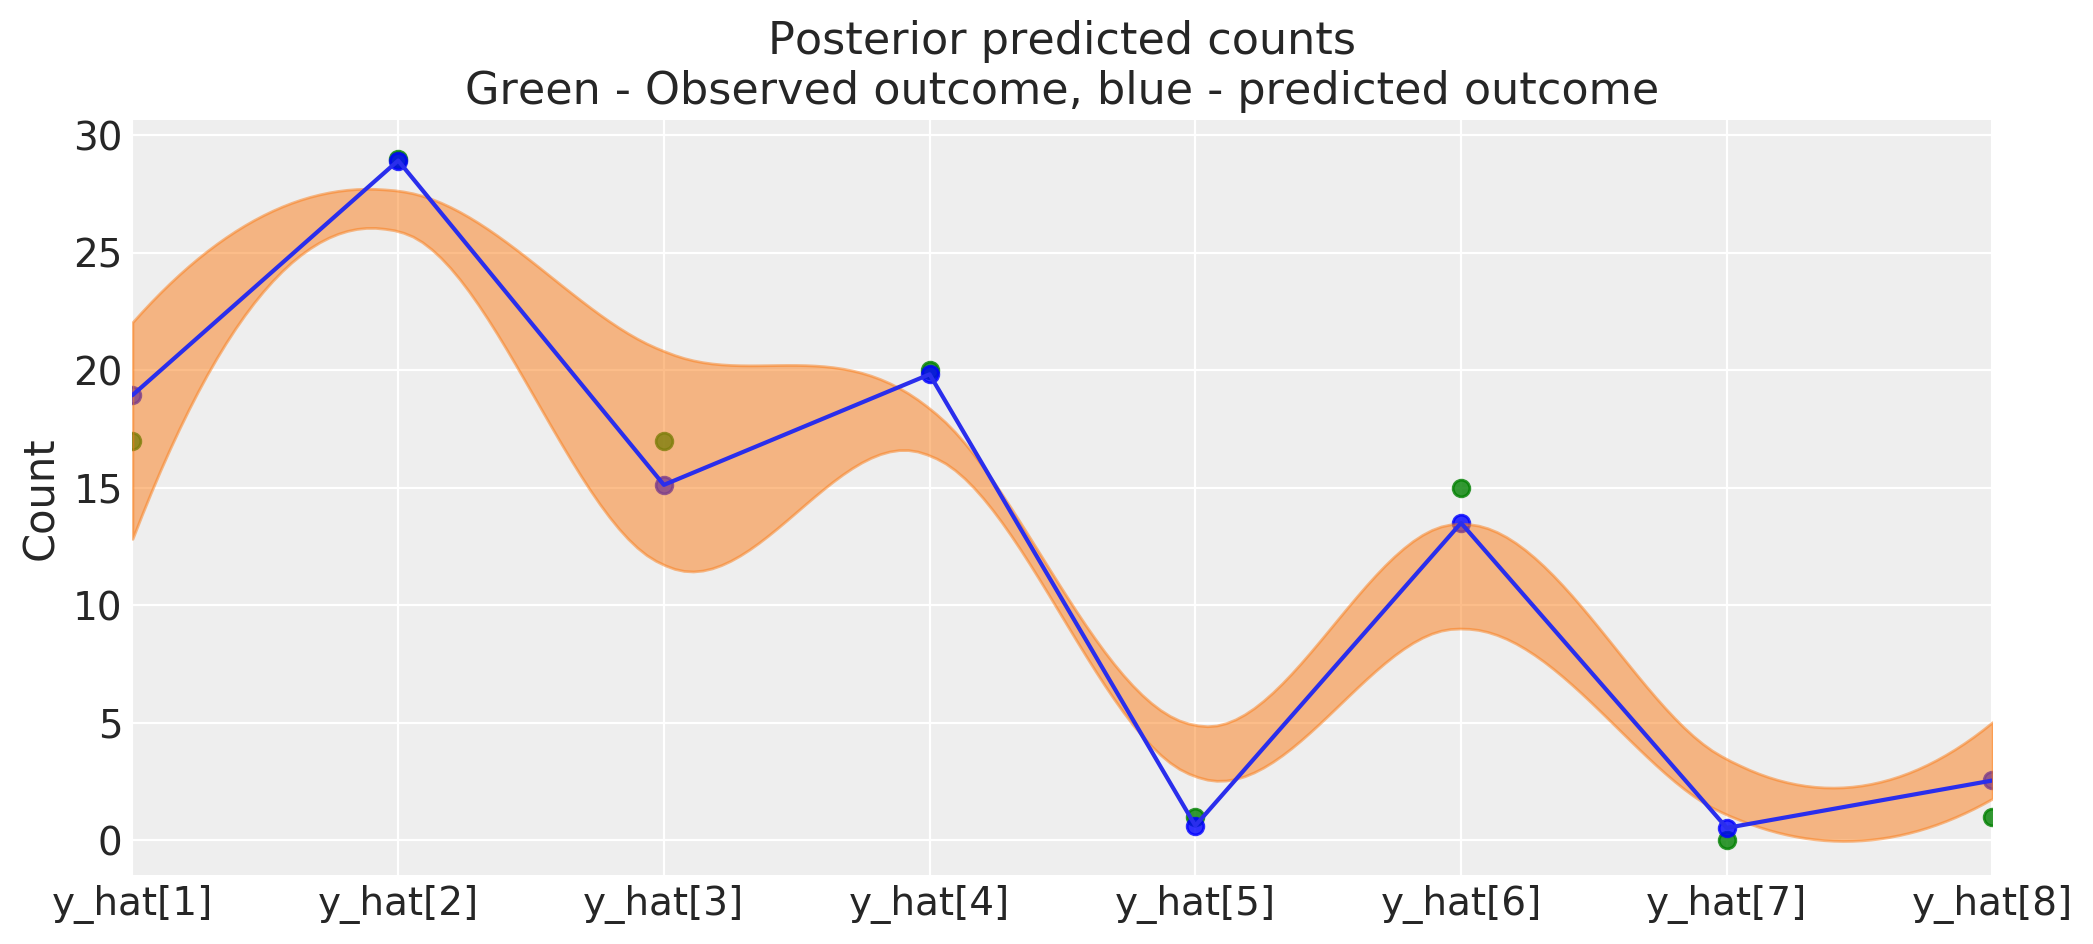

In [38]:
# Not sure why HPD interval misses everything
import matplotlib.pyplot as plt
expected_count = post_pred_check_df.mean(0)

plt.figure(figsize=(12,5))
plt.scatter(df.index, df.y, color='green', alpha=0.8)
plt.scatter(df.index, expected_count, color='blue', alpha=0.8)
expected_count.plot()
az.plot_hpd(df.index, post_pred_check_df, credible_interval=0.89);
plt.ylabel("Count")
plt.title("Posterior predicted counts\nGreen - Observed outcome, blue - predicted outcome", y = 1)


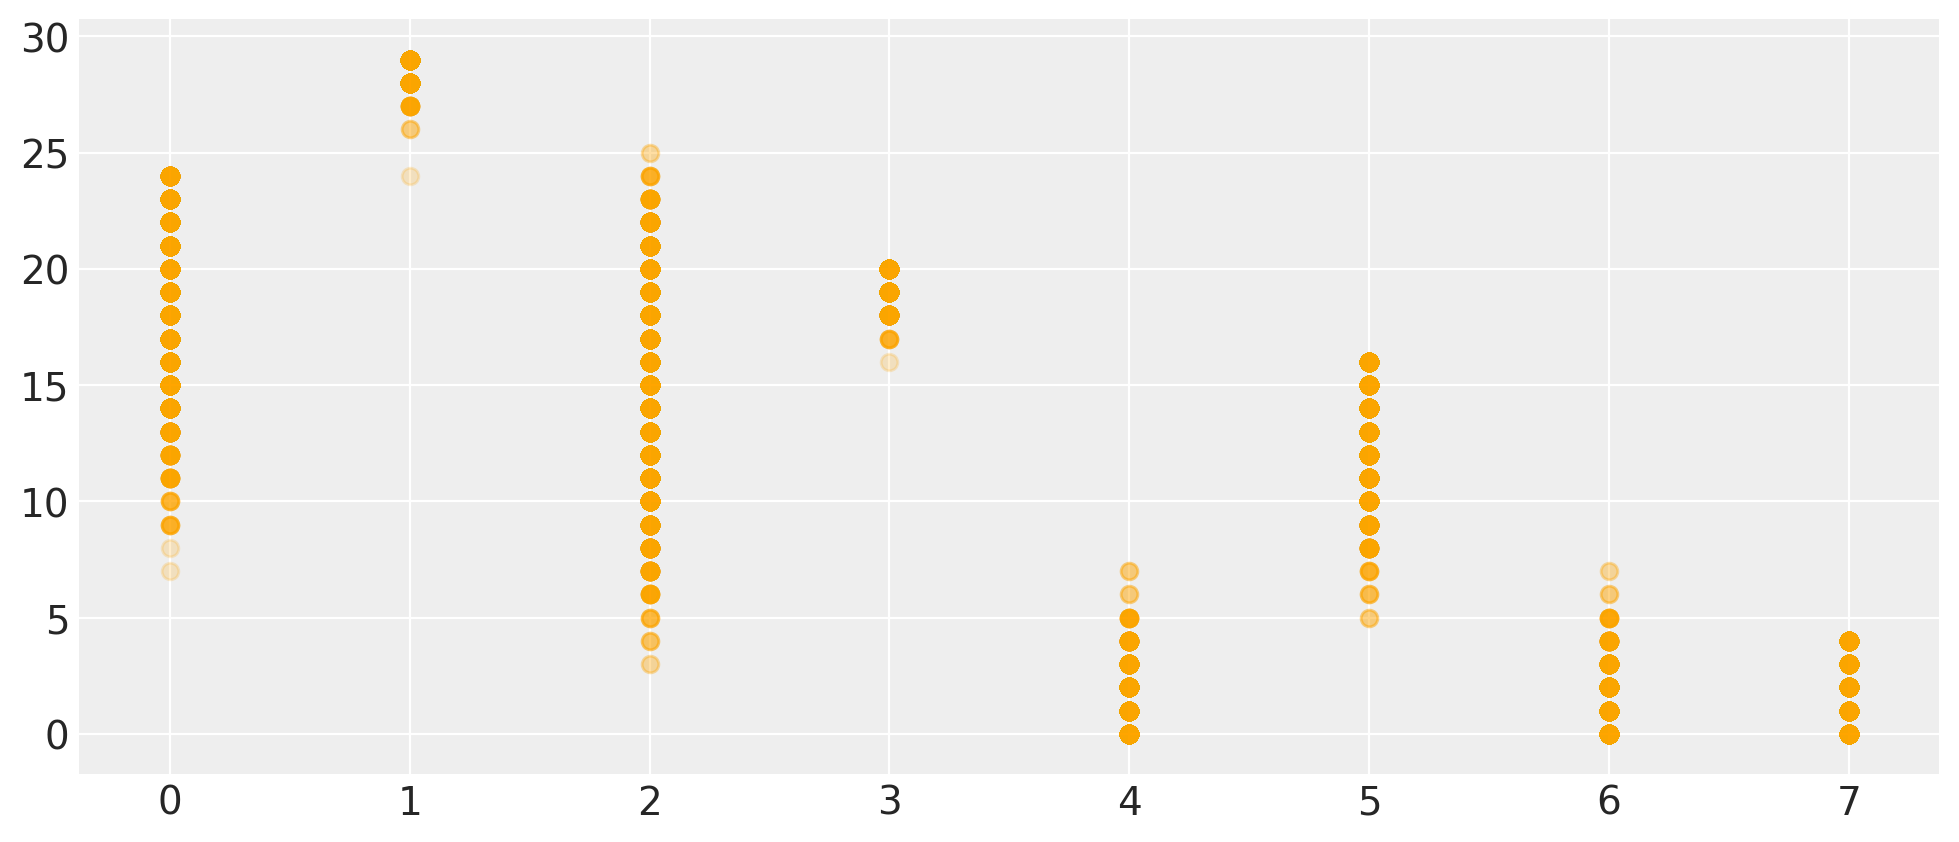

In [39]:
# Posterior predictive distribution (better than HPD)
plt.figure(figsize=(12,5))

for i in range(len(post_pred_check_df)):
    plt.scatter(df.index, post_pred_check_df.T[i], color='orange', alpha=0.2)


### 10H3c

In [40]:
df['PA'] = df.P * df.A
df.head()

,y,n,P,A,V,PA
0,17,24,1,1,1,1
1,29,29,1,1,0,1
2,17,27,1,0,1,0
3,20,20,1,0,0,0
4,1,12,0,1,1,0


In [43]:
h3_2 = '''
data {
    int<lower=0> N;
    int<lower=0> y[N]; // Number of pulls
    int<lower=0> T[N]; // Number of trials
    vector[N] P;
    vector[N] A;
    vector[N] V;
    vector[N] PA;
}
parameters {
    real a;
    real bP;
    real bA;
    real bV;
    real bPA
}
model {
    vector[N] p;
    target += normal_lpdf(bP | 0,5);
    target += normal_lpdf(bA | 0,5);
    target += normal_lpdf(bV | 0,5);
    target += normal_lpdf(bPA | 0,5);
    
    for(n in 1:N) p[n] = a + bP * P[n] + bA * A[n] + bV * V[n] + bPA * PA[n];
    target += binomial_logit_lpmf(y | T, p);
}
generated quantities {
    vector[N] log_lik;
    vector[N] y_hat;
    vector[N] p;
    {
    for(n in 1:N){
        p[n] = a + bP * P[n] + bA * A[n] + bV * V[n] + bPA * PA[n];
        log_lik[n] = binomial_logit_lpmf(y[n] | T[n], p[n]);
        y_hat[n] = binomial_rng(T[n], inv_logit(p[n]));
        } 
    }
}
'''

In [44]:
eagles_df = dict(N=len(df),
                 y = df['y'],
                 T = df['n'],
                 P = df['P'],
                 A = df['A'],
                 V = df['V'],
                 PA = df['PA'])

sm_h3_2 = pystan.StanModel(model_code=h3_2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8d0b9456feb24ad998d1cdc73d77c916 NOW.


In [45]:
fit_h3_2 = sm_h3_2.sampling(data=eagles_df)
fit_h3_2

Inference for Stan model: anon_model_8d0b9456feb24ad998d1cdc73d77c916.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a           -0.79    0.03   1.02  -2.92  -1.43  -0.74   -0.1   1.06   1111    1.0
bP           6.54    0.05   1.44   4.14   5.49   6.41   7.41    9.7   1013    1.0
bA           3.43    0.04    1.2   1.26   2.56   3.36   4.21   5.94    930    1.0
bV          -5.25    0.03   1.16  -7.99  -5.91  -5.16  -4.45  -3.25   1467    1.0
bPA         -2.94    0.04   1.32  -5.66  -3.78  -2.87  -2.01  -0.57    963    1.0
log_lik[1]  -2.26    0.01   0.72  -4.31  -2.45  -1.99  -1.79  -1.73   2609    1.0
log_lik[2]  -0.11  2.8e-3   0.13  -0.46  -0.13  -0.06  -0.03-3.4e-3   2227    1.0
log_lik[3]  -2.37    0.02   0.71  -4.36  -2.55  -2.08   -1.9  -1.85   2155    1.0
log_lik[4]  -0.12  3.2e-3   0.14  -0.52  -0.15  -0.07  -0.03-3.7e-3   200

In [47]:
ll_h3_1 = az.from_pystan(fit_h3_1, log_likelihood="log_lik")
ll_h3_2 = az.from_pystan(fit_h3_2, log_likelihood="log_lik")

compare_dict = {'h3_1' : ll_h3_1,
                'h3_2' : ll_h3_2}

az.compare(compare_dict, ic="waic")

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
h3_2,0,20.642,2.0132,0,0.98315,7.07575,0,True,deviance
h3_1,1,30.4767,5.093,9.83473,0.0168505,5.2619,3.35303,True,deviance


## 10H4

In [48]:
sal = pd.read_csv('/Users/benjaminwee/Documents/courses/resources/Rethinking/Data/salamanders.csv',
                 sep = ';')

def z_score(x):
    z = (x - x.mean())/x.std()
    return z

sal['PCTCOVER_z'] = z_score(sal['PCTCOVER'])
sal['FORESTAGE_z'] = z_score(sal['FORESTAGE'])

In [49]:
sal.head()

,SITE,SALAMAN,PCTCOVER,FORESTAGE,PCTCOVER_z,FORESTAGE_z
0,1,13,85,316,0.727323,0.760627
1,2,11,86,88,0.755274,-0.417586
2,3,11,90,548,0.867079,1.959512
3,4,9,88,64,0.811176,-0.541609
4,5,8,89,43,0.839127,-0.650129


In [78]:
h4_1 = '''
data {
    int<lower=0> N;
    int<lower=0> SALAMAN[N]; // Density
    
    vector[N] PCTCOVER_z;
}
parameters {
    real a;
    real bp;
}
model {
    vector[N] lambda;
    target += normal_lpdf(a | 0,1);
    target += normal_lpdf(bp | 0,1);
    
    for(n in 1:N) lambda[n] = a + bp * PCTCOVER_z[n];
    target += poisson_log_lpmf(SALAMAN | lambda);
}
generated quantities {
    vector[N] log_lik;
    vector[N] lambda;
    vector[N] y_hat;
    {
    for(n in 1:N){
        lambda[n] = a + bp * PCTCOVER_z[n];
        log_lik[n] = poisson_log_lpmf(SALAMAN[n] | lambda[n]);
        y_hat[n] = poisson_rng(exp(lambda[n]));
        }
    }
}
'''

In [79]:
sm_h4_1 = pystan.StanModel(model_code=h4_1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c93f2a1e2fd2a38445b3fcf2c80b3eb1 NOW.


In [80]:
df_h4 = dict(N=len(sal),
             SALAMAN = sal.SALAMAN,
             PCTCOVER_z = sal.PCTCOVER_z)

In [81]:
fit_h4_1 = sm_h4_1.sampling(data=df_h4)
fit_h4_1


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_c93f2a1e2fd2a38445b3fcf2c80b3eb1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a             0.44  4.8e-3   0.15   0.14   0.34   0.44   0.54   0.72    960    1.0
bp            1.14  5.9e-3   0.18   0.79   1.01   1.14   1.26   1.49    940    1.0
log_lik[1]   -9.67    0.01   0.87 -11.45 -10.24  -9.64  -9.07  -8.07   4534    1.0
log_lik[2]   -6.91 10.0e-3   0.68  -8.32  -7.36  -6.88  -6.44  -5.68   4615    1.0
log_lik[3]   -6.01 10.0e-3   0.68  -7.45  -6.46  -5.99  -5.54  -4.79   4590    1.0
log_lik[4]   -4.48  7.1e-3   0.49  -5.52  -4.79  -4.45  -4.13  -3.61   4658    1.0
log_lik[5]   -3.51  5.7e-3   0.39  -4.35  -3.76  -3.49  -3.24  -2.84   4617    1.0
log_lik[6]   -3.46  5.2e-3   0.33  -4.15  -3.67  -3.44  -3.22  -2.86   4060    1.0
log_lik[7]   -2.71  3.8e